In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import pandas as pd
import torch.optim as optim
import glob
from torch.utils.data import TensorDataset, DataLoader

In [2]:
#选择在GPU或CPU上面运行
device=torch.device('cuda:0' if torch.cuda.is_available else 'cpu')
print(device)

cuda:0


In [3]:
M = 10020
data = []
labels = []

# 拿到数据路径，方便后续读取
dir_path = 'D:\\Desktop\\Python\\Length_width\\Data\\train'
# 获取目录及其子目录下所有CSV文件的路径
dataPaths = sorted(glob.glob(os.path.join(dir_path, '**', '*.csv'), recursive=True))
random.seed(42)
random.shuffle(dataPaths)

# 遍历读取数据
for dataPath in dataPaths:
    # 读取数据
    data_1 = pd.read_csv(dataPath)
    
    # 检查第一列的每一行，找到第一个大于0的值的位置N
    for N in range(len(data_1)):
        if data_1.iloc[N, 0] > 0:
            break
    
    # 如果找到了大于0的值，则从第二列的第N行开始，往后取10020个点
    if N < len(data_1):  # 确保N不会超出索引范围
        data.append(data_1.iloc[N:N+M, 1])
    
    # 从文件名中提取x, y, z标签
    filename = os.path.basename(dataPath)
    # 假设文件名格式为 "some_prefix_label1_label2.csv"
    parts = filename.split('_')
    # 提取最后一个"_"之前的部分作为prefix，之后的作为label1
    label1_str = parts[0]
    # 提取最后一个".csv"之前的部分作为label2
    label2_str = parts[1]
    
    # 将字符串标签转换为浮点数
    label1 = float(label1_str)
    label2 = float(label2_str)
    
    # 将两个标签值作为一个数组添加到labels列表中
    labels.append([label1, label2])

# 将数据和标签转换为numpy数组
train_data = np.array(data, dtype="float")
train_labels = np.array(labels)

In [4]:
data = []
labels = []

# 拿到数据路径，方便后续读取
dir_path = 'D:\\Desktop\\Python\\Length_width\\Data\\validation'
# 获取目录及其子目录下所有CSV文件的路径
dataPaths = sorted(glob.glob(os.path.join(dir_path, '**', '*.csv'), recursive=True))
random.seed(42)
random.shuffle(dataPaths)

# 遍历读取数据
for dataPath in dataPaths:
    # 读取数据
    data_1 = pd.read_csv(dataPath)
    
    # 检查第一列的每一行，找到第一个大于0的值的位置N
    for N in range(len(data_1)):
        if data_1.iloc[N, 0] > 0:
            break
    
    # 如果找到了大于0的值，则从第二列的第N行开始，往后取10020个点
    if N < len(data_1):  # 确保N不会超出索引范围
        data.append(data_1.iloc[N:N+M, 1])
    
    # 从文件名中提取x, y, z标签
    filename = os.path.basename(dataPath)
    # 假设文件名格式为 "some_prefix_label1_label2.csv"
    parts = filename.split('_')
    # 提取最后一个"_"之前的部分作为prefix，之后的作为label1
    label1_str = parts[0]
    # 提取最后一个".csv"之前的部分作为label2
    label2_str = parts[1]
    
    # 将字符串标签转换为浮点数
    label1 = float(label1_str)
    label2 = float(label2_str)
    
    # 将两个标签值作为一个数组添加到labels列表中
    labels.append([label1, label2])

# 将数据和标签转换为numpy数组
validation_data = np.array(data, dtype="float")
validation_labels = np.array(labels)

In [5]:
train_datas = train_data.reshape(-1,train_data.shape[1],1)
print(train_datas.shape)
validation_datas = validation_data.reshape(-1,validation_data.shape[1],1)
print(validation_datas.shape)

(1902, 10020, 1)
(218, 10020, 1)


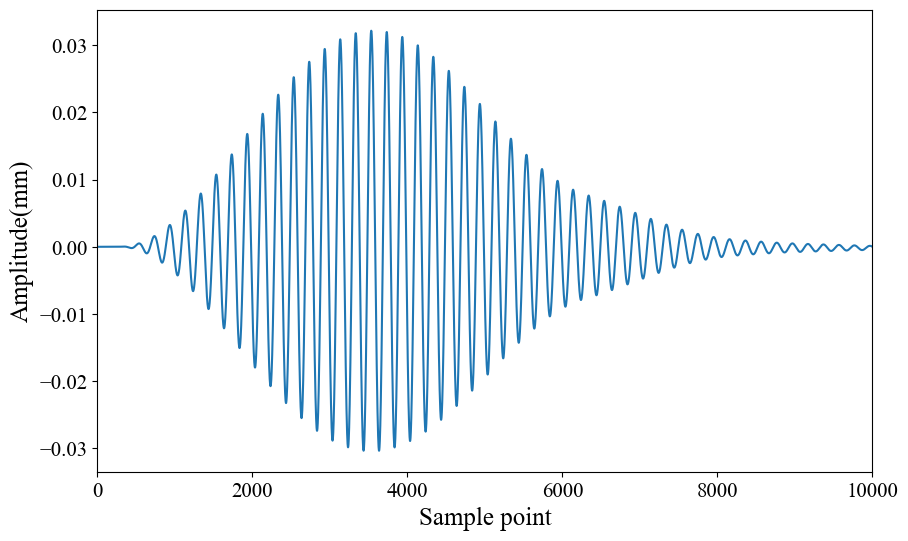

In [6]:
plt.style.use('default')
plt.figure(figsize=(10,6))
plt.rcParams['font.family'] = ['Times New Roman']
plt.plot(train_datas[1,:],linewidth=1.5)
plt.xlabel('Sample point',fontdict={'weight': 'normal', 'size': 18})
plt.ylabel('Amplitude(mm)',fontdict={'weight': 'normal', 'size': 18})
#坐标轴刻度大小设置
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xlim([0,10000])
plt.savefig('D:\\Desktop\\Python\\Length_width\\Model\\NUT-DBLSTM\\train_data.jpg', dpi=600, bbox_inches='tight')

In [7]:
BATCH_SIZE = 20
EPOCH = 6000
learning_rate = 1e-4
input_size=  10020   # 输入特征维度
output_size = 2         # 输出维度

max_seq_len = 1000         # 最大序列长度
model_dim = 100
num_heads = 4
num_layers = 2

In [8]:
# 准备数据
#torch.from_numpy将 NumPy 数组转换为 PyTorch 张量
#TensorDataset用于将张量数据和标签组合成一个数据集
#DataLoader用于从数据集中加载批次数据，并进行训练或测试

train_dataset = TensorDataset(torch.from_numpy(train_datas),torch.from_numpy(train_labels))
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

validation_dataset = TensorDataset(torch.from_numpy(validation_datas),torch.from_numpy(validation_labels))
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [9]:
class TransformerPredictor(nn.Module):
    def __init__(self, input_size, model_dim, num_heads, num_layers, output_size, max_seq_len):
        super(TransformerPredictor, self).__init__()
        self.model_dim = model_dim

        # 输入嵌入层
        self.embedding = nn.Linear(input_size, model_dim)

        # 位置编码
        self.positional_encoding = nn.Parameter(torch.zeros(1, max_seq_len, model_dim))

        # Transformer 编码器
        self.transformer_encoder_layer = nn.TransformerEncoderLayer(
            d_model=model_dim,
            nhead=num_heads,
            dim_feedforward=model_dim * 4  # 前馈网络的隐藏层维度
        )
        self.transformer_encoder = nn.TransformerEncoder(self.transformer_encoder_layer, num_layers=num_layers)

        # 全连接层
        self.fc1 = nn.Linear(model_dim, model_dim // 2)
        self.fc2 = nn.Linear(model_dim // 2, model_dim // 4)
        self.fc3 = nn.Linear(model_dim // 4, output_size)
        self.activate = nn.Tanh()

    def forward(self, x):
        # 输入嵌入
        x = self.embedding(x)  # 形状: (batch_size, 1, model_dim)

        # 添加位置编码
        seq_len = x.size(1)
        x = x + self.positional_encoding[:, :seq_len, :]

        # Transformer 编码器前向传播
        x = x.permute(1, 0, 2)  # 转换为 (1, batch_size, model_dim)
        transformer_out = self.transformer_encoder(x)  # 形状: (1, batch_size, model_dim)
        transformer_out = transformer_out.permute(1, 0, 2)  # 转换回 (batch_size, 1, model_dim)

        # 取最后一个时间步的输出
        out1 = self.activate(transformer_out[:, -1, :])  # 形状: (batch_size, model_dim)

        # 全连接层
        out2 = self.fc1(out1)
        out3 = self.fc2(out2)
        out4 = self.fc3(out3)
        return out4

In [10]:
#模型实例化
model = TransformerPredictor(input_size, model_dim, num_heads, num_layers, output_size,max_seq_len)
model.to(device)
loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

c:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [11]:
#两个空列表用于存储训练和验证中的损失值
train_loss_length_epoch = []
train_loss_width_epoch = []

#两个空列表用于存储训练和验证中的损失值
validation_loss_length_epoch = []
validation_loss_width_epoch = []

A = 1
B = 0.1

In [12]:
#训练和验证阶段
for epoch in range(EPOCH):
    if epoch % (EPOCH/10)==0:
        print("-------第 {} 轮训练开始-------".format(epoch+1)) 

    train_length_epoch = 0.0 #这段代码放在epoch循环中，每次循环时清零
    train_width_epoch = 0.0 #这段代码放在epoch循环中，每次循环时清零

    # 训练步骤开始
    model.train() #在训练模式下，模型会计算并反向传播误差，并更新模型参数   
    for i, (x, y) in enumerate(train_loader):
        optimizer.zero_grad() #在使用优化器更新参数之前，我们需要先将模型参数的梯度清零，
                              #以避免之前的梯度对当前梯度的影响
        
        x1=x.type(torch.FloatTensor)
        x2 = x1.permute(0,2,1) #将x1的维度进行调换，该例中将第1个维度保持不变，第2个维度和第3个进行交换

        length1=y[:,0].type(torch.FloatTensor)
        width1=y[:,1].type(torch.FloatTensor)

        x3, length2,width2 = x2.to(device), length1.to(device),width1.to(device)

        length_hat = model(x3)[:,0]
        width_hat=model(x3)[:,1]

        train_loss_length = A* loss(length_hat, length2)
        train_loss_width = B* loss(width_hat, width2)
        
        train_loss_length.backward()
        train_loss_width.backward()

        optimizer.step()

        train_length_epoch += train_loss_length.item() * x3.size(0)
        
        train_width_epoch += train_loss_width.item() * x3.size(0) 
    #计算一个 epoch 内的平均训练损失
    train_mean_length = train_length_epoch / len(train_loader.dataset)
    #将平均训练损失 train_mean_loss 添加到 train_loss_mean 列表中
    train_loss_length_epoch.append([train_mean_length])

    train_mean_width = train_width_epoch / len(train_loader.dataset)
    train_loss_width_epoch.append([train_mean_width])

    # 验证步骤开始
    model.eval() 
    validation_length_epoch = 0.0 #这段代码放在epoch循环中，每次循环时清零
    validation_width_epoch = 0.0 #这段代码放在epoch循环中，每次循环时清零

    with torch.no_grad():
        for i, (x, y) in enumerate(validation_loader):
            
            x1=x.type(torch.FloatTensor)
            x2 = x1.permute(0,2,1) #将x1的维度进行调换，该例中将第1个维度保持不变，第2个维度和第3个进行交换

            length1 = y[:,0].type(torch.FloatTensor)
            width1 = y[:,1].type(torch.FloatTensor)

            x3, length2,width2 = x2.to(device), length1.to(device),width1.to(device)

            length_hat = model(x3)[:,0]
            width_hat = model(x3)[:,1]

            validation_loss_length = A* loss(length_hat, length2)
            validation_loss_width = B* loss(width_hat, width2)
            
            validation_length_epoch += validation_loss_length.item() * x3.size(0)
            
            validation_width_epoch += validation_loss_width.item() * x3.size(0) 
        #计算一个 epoch 内的平均训练损失
        validation_mean_length = validation_length_epoch / len(validation_loader.dataset)
        #将平均训练损失 train_mean_loss 添加到 train_loss_mean 列表中
        validation_loss_length_epoch.append([validation_mean_length])

        validation_mean_width = validation_width_epoch / len(validation_loader.dataset)
        validation_loss_width_epoch.append([validation_mean_width])          

    if epoch % (EPOCH/10) == 0:
        print(f"Epoch:{epoch}, Train_Length_Loss: {train_mean_length:.4f}, Train_Width_Loss: {train_mean_width:.4f},\n"
      f"Validation_Length_Loss: {validation_mean_length:.4f}, Validation_Width_Loss: {validation_mean_width:.4f}")

-------第 1 轮训练开始-------
Epoch:0, Train_Length_Loss: 30.1518, Train_Width_Loss: 0.0342,
Validation_Length_Loss: 9.7886, Validation_Width_Loss: 0.0239
-------第 601 轮训练开始-------
Epoch:600, Train_Length_Loss: 0.0432, Train_Width_Loss: 0.0024,
Validation_Length_Loss: 0.0298, Validation_Width_Loss: 0.0023
-------第 1201 轮训练开始-------
Epoch:1200, Train_Length_Loss: 0.0211, Train_Width_Loss: 0.0023,
Validation_Length_Loss: 0.0140, Validation_Width_Loss: 0.0021
-------第 1801 轮训练开始-------
Epoch:1800, Train_Length_Loss: 0.0186, Train_Width_Loss: 0.0019,
Validation_Length_Loss: 0.0245, Validation_Width_Loss: 0.0015
-------第 2401 轮训练开始-------
Epoch:2400, Train_Length_Loss: 0.0126, Train_Width_Loss: 0.0016,
Validation_Length_Loss: 0.0076, Validation_Width_Loss: 0.0009
-------第 3001 轮训练开始-------
Epoch:3000, Train_Length_Loss: 0.0118, Train_Width_Loss: 0.0013,
Validation_Length_Loss: 0.0049, Validation_Width_Loss: 0.0006
-------第 3601 轮训练开始-------
Epoch:3600, Train_Length_Loss: 0.0110, Train_Width_Loss:

In [13]:
torch.save(model, 'D:\\Desktop\\Python\\Length_width\\Model\\NUT-DBLSTM\\model_Length_width_transformer.pth') 
print("模型已保存")

模型已保存


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


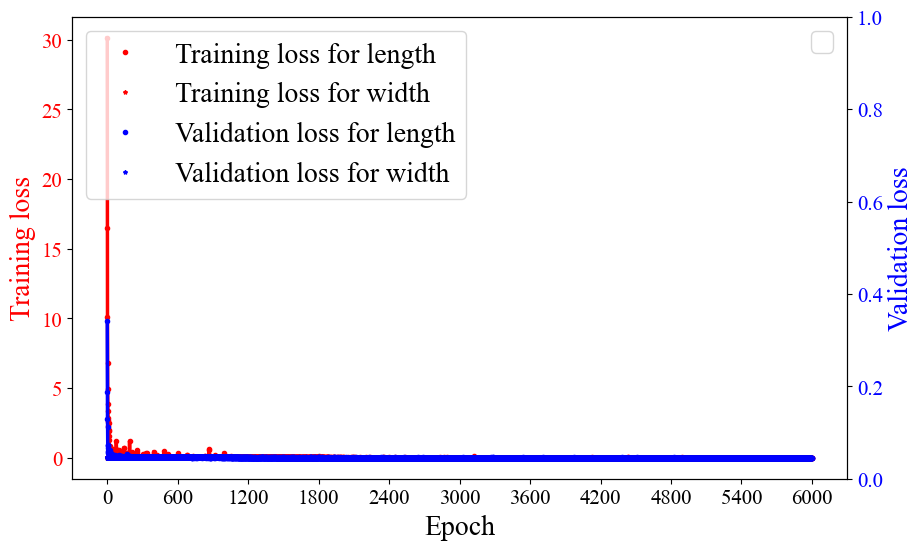

In [15]:
plt.style.use('default')
plt.figure(figsize=(10, 6)) # 创建Figure对象，并指定尺寸
plt.rcParams['font.family'] = ['Times New Roman']

# 创建第一个y轴
ax1 = plt.gca()
ax1.plot(train_loss_length_epoch, 'r-', linewidth=2.5)
ax1.plot(train_loss_length_epoch, marker='o', markersize=3, color='red', linestyle='None', label='Training loss for length')
ax1.plot(train_loss_width_epoch, 'r-', linewidth=2.5)
ax1.plot(train_loss_width_epoch, marker='*', markersize=3, color='red', linestyle='None', label='Training loss for width')

ax1.set_xlabel('Epoch', fontdict={'weight': 'normal', 'size': 20})
ax1.set_ylabel('Training loss', fontdict={'weight': 'normal', 'size': 20}, color='red')

ax1.tick_params(axis='y', labelcolor='red')
ax1.tick_params(axis='both', which='major', labelsize=15)

# 创建第二个y轴
ax2 = ax1.twinx()
ax1.plot(validation_loss_length_epoch, 'b-', linewidth=2.5)
ax1.plot(validation_loss_length_epoch, marker='o', markersize=3, color='blue', linestyle='None', label='Validation loss for length')
ax1.plot(validation_loss_width_epoch, 'b-', linewidth=2.5)
ax1.plot(validation_loss_width_epoch, marker='*', markersize=3, color='blue', linestyle='None', label='Validation loss for width')

ax2.set_ylabel('Validation loss', fontdict={'weight': 'normal', 'size': 20}, color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.tick_params(axis='both', which='major', labelsize=15)

# 设置x轴刻度
epoch = np.arange(0,EPOCH+1,EPOCH/10)
plt.xticks(epoch)

# 添加图例
ax1.legend(loc='upper left', fontsize=20)
ax2.legend(loc='upper right', fontsize=20)

# 保存图像
plt.savefig('D:\\Desktop\\Python\\Length_width\\Model\\NUT-DBLSTM\\Model_Loss_transformer.jpg', dpi=600, bbox_inches='tight')
plt.show()